### Load the train and test data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

np.random.seed(43)

In [2]:
train_df = pd.read_csv("data/train/train_data.csv", header=0, index_col=False)

test_df = pd.read_csv("data/test/test_data.csv", header=0)

In [3]:
train_df

,time,x-acceleration,y-acceleration,z-acceleration,output
0,0.00,0.577,0.532,0.598,drum
1,0.02,0.587,0.539,0.600,drum
2,0.04,0.590,0.537,0.595,drum
3,0.06,0.589,0.533,0.591,drum
4,0.08,0.584,0.534,0.590,drum
...,...,...,...,...,...
19396,387.92,0.862,0.362,0.372,NaN
19397,387.94,0.864,0.357,0.371,NaN
19398,387.96,0.867,0.350,0.372,NaN
19399,387.98,0.867,0.344,0.371,NaN


#### Cleanup DONE


In [4]:
# Renaming some columns
train_df.rename(
    columns={"x-acceleration": "x", "y-acceleration": "y", "z-acceleration": "z"},
    inplace=True
)

test_df.rename(
    columns={"x-acceleration": "x", "y-acceleration": "y", "z-acceleration": "z"},
    inplace=True
)

In [5]:
train_df.columns

Index(['time', 'x', 'y', 'z', 'output'], dtype='object')

##### Encoding of labels

In [6]:
train_df["output"].value_counts().sort_index()

output
drum      4265
guitar    6050
piano     5156
Name: count, dtype: int64

In [7]:
test_df["output"].value_counts().sort_index()

output
drum      3251
guitar    3500
piano     3250
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

# Train set
train_labels = train_df["output"]
train_labels_encoded = encoder.fit_transform(train_labels)

train_df["output"] = train_labels_encoded

#Test set
test_labels = test_df["output"]
test_labels_encoded = encoder.fit_transform(test_labels)

test_df["output"] = test_labels_encoded

In [9]:
train_df["output"]

0        0
1        0
2        0
3        0
4        0
        ..
19396    3
19397    3
19398    3
19399    3
19400    3
Name: output, Length: 19401, dtype: int32

#### Data plots DONE??

C:\Users\Isabella\AppData\Local\Temp\ipykernel_28068\1101153440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=train_df, x="output", palette="pastel")


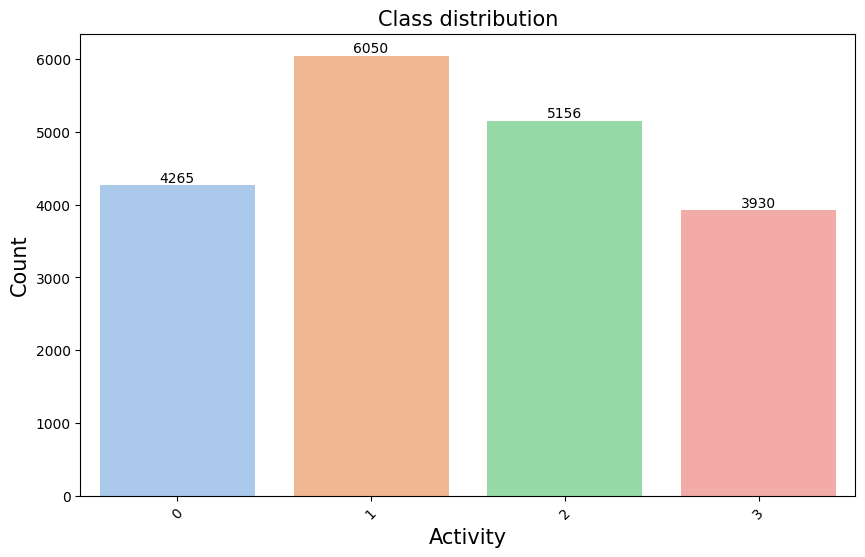

In [10]:
# Plot the distribution of the activities
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_df, x="output", palette="pastel")
plt.title("Class distribution", fontsize=15)
plt.xlabel("Activity", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.xticks(rotation=45)

for p in ax.containers:
    ax.bar_label(p)

plt.show()

# Plot the distribution of the activities
# plt.figure(figsize=(10, 6))
# ax = sns.countplot(data=test_df, x="output", palette="pastel")
# plt.title("Class distribution", fontsize=15)
# plt.xlabel("Activity", fontsize=15)
# plt.ylabel("Count", fontsize=15)
# plt.xticks(rotation=45)

# for p in ax.containers:
#     ax.bar_label(p)

# plt.show()

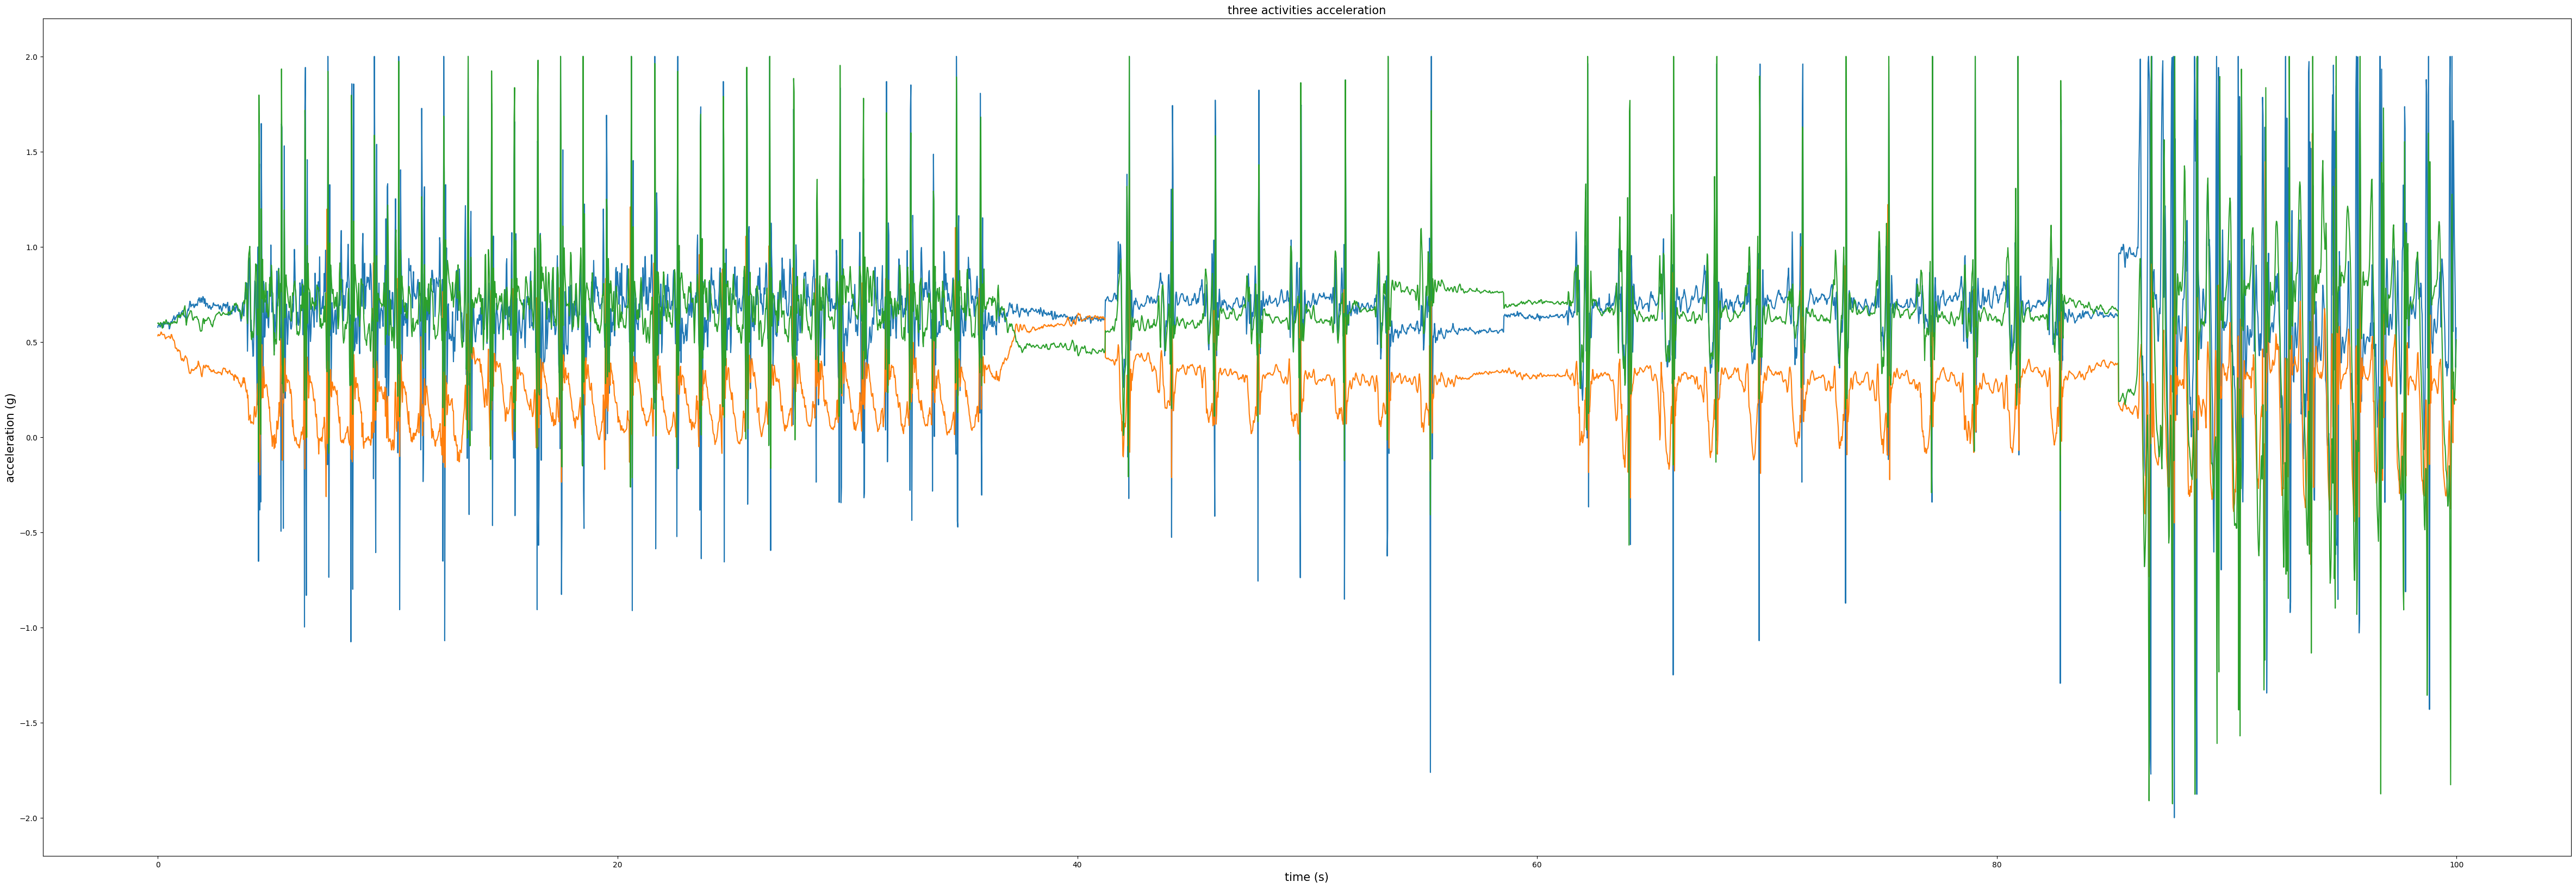

In [11]:
fig = plt.subplots(figsize=(60, 20))

plt.title("three activities acceleration", fontsize=15)
plt.xlabel("time (s)", fontsize=15)
plt.ylabel("acceleration (g)", fontsize=15)

plt.rcParams["axes.xmargin"] = 0
plt.rcParams["axes.ymargin"] = 0.08

for col in ["x", "y", "z"]:
    plt.plot(train_df.iloc[:5000, 0], train_df[col][:5000], label=col)


### Feature extraction

#### Euclidean norm

In [12]:
# Euclidean norm of samples across the 3 axes, stored in "a" for acceleration
train_df["a"] = train_df.loc[:, ["x", "y", "z"]].apply(np.linalg.norm, axis=1)

train_df.head()

,time,x,y,z,output,a
0,0.00,0.577,0.532,0.598,0,0.986690
1,0.02,0.587,0.539,0.600,0,0.997542
2,0.04,0.590,0.537,0.595,0,0.995236
3,0.06,0.589,0.533,0.591,0,0.990096
4,0.08,0.584,0.534,0.590,0,0.987072


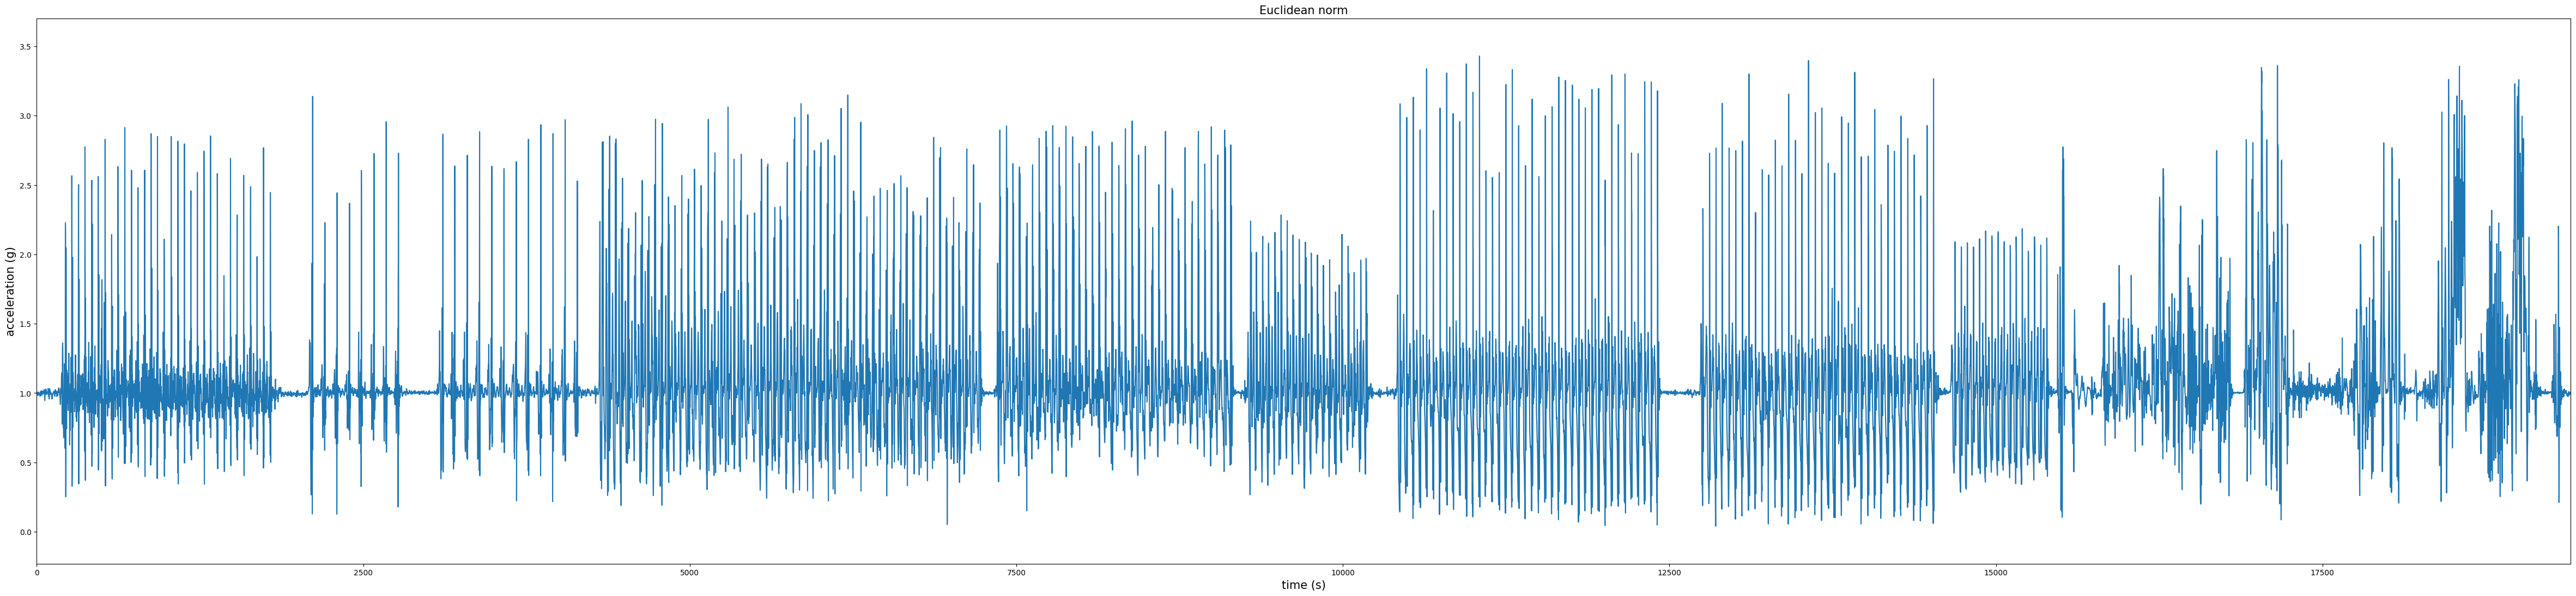

In [13]:
# Plot of all mean values for all samples
fig = plt.subplots(figsize=(60, 13))

plt.title("Euclidean norm", fontsize=15)
plt.xlabel("time (s)", fontsize=15)
plt.ylabel("acceleration (g)", fontsize=15)

plt.plot(train_df["a"])

#### Sliding window

##### On the training set

Statistical features to calculate the correlation between each feature and the target label 

In [14]:
window = 150  # samples for every 3 seconds
F = pd.DataFrame() 
count = 0

In [15]:
for x in range(0, len(train_df), window):
    # Check that the window has sufficient samples
    if (x + window) < len(train_df):
        count += 1
        d = train_df.loc[x : x + window, :]  # Rows in window range, all columns

        # Calculate features
        feature_values = {
            "sample": x,
            "time": d.iloc[window // 2]["time"],
            "a_mean": d["a"].mean(),
            "a_std": d["a"].std(),
            "x_mean": d["x"].mean(),
            "y_mean": d["y"].mean(),
            "z_mean": d["z"].mean(),
            # "x_zero_cross": np.sum(np.diff(np.sign(d["x"])) != 0) / len(d["x"]),
            # "y_zero_cross": np.sum(np.diff(np.sign(d["y"])) != 0) / len(d["y"]),
            # "z_zero_cross": np.sum(np.diff(np.sign(d["z"])) != 0) / len(d["z"]),
            # "skew": d["a"].skew(),
            "output": d.iloc[window // 2]["output"].astype(int)
        }

        F = pd.concat([F, pd.DataFrame(feature_values, index=[0])], ignore_index=True)

        # print("Window: " + str(count))
        # print("Sample x: " + str(x))

In [16]:
F["output"].value_counts().sort_index()

output
0    28
1    41
2    34
3    26
Name: count, dtype: int64

In [17]:
# F.describe()

In [18]:
# F.plot(x = "time", y = ["a_mean", "x_mean", "y_mean", "z_mean"], figsize = (10, 6))
# plt.xlabel("time")
# plt.ylabel("mean")
# plt.title("Mean acceleration")

# plt.show()

##### On the test set

In [19]:
test_df["a"] = test_df.loc[:, ["x", "y", "z"]].apply(np.linalg.norm, axis=1)

window = 150
count = 0
F_test = pd.DataFrame()

for x in range(0, len(test_df), window):
    # Check that the window has sufficient samples
    if (x + window) < len(test_df):
        count += 1
        d_1 = test_df.loc[x : x + window, :]  # Rows in window range, all columns

        # Calculate features
        test_values = {
            "sample": x,
            "time": d_1.iloc[window // 2]["time"],
            "a_mean": d_1["a"].mean(),
            "a_std": d_1["a"].std(),
            "x_mean": d_1["x"].mean(),
            "y_mean": d_1["y"].mean(),
            "z_mean": d_1["z"].mean(),
            # "x_zero_cross": np.sum(np.diff(np.sign(d_1["x"])) != 0) / len(d_1["x"]),
            # "y_zero_cross": np.sum(np.diff(np.sign(d_1["y"])) != 0) / len(d_1["y"]),
            # "z_zero_cross": np.sum(np.diff(np.sign(d_1["z"])) != 0) / len(d_1["z"]),
            # "skew": d_1["a"].skew(),
            "output": d_1.iloc[window // 2]["output"].astype(int),
        }

        F_test = pd.concat(
            [F_test, pd.DataFrame(test_values, index=[0])], ignore_index=True
        )

F_test.head()

,sample,time,a_mean,a_std,x_mean,y_mean,z_mean,output
0,0,1.5,1.005953,0.245032,0.685629,0.035854,0.695894,0
1,150,4.5,1.015011,0.260249,0.695106,-0.120894,0.688510,0
2,300,7.5,1.045551,0.348779,0.657868,-0.159788,0.713662,0
3,450,10.5,1.025341,0.263934,0.663166,-0.151066,0.717311,0
4,600,13.5,1.022074,0.299311,0.719298,-0.114404,0.666311,0


## Incremental review of different models

### Model 1: Decision Trees

In [20]:
from sklearn import tree

X = F.drop(columns=["sample", "time", "output"])
y = F["output"]

dt = tree.DecisionTreeClassifier()
dt.fit(X, y)

DecisionTreeClassifier()

Make the predictions

In [21]:
X_test = F_test.drop(columns=["sample", "time", "output"])
y_predict_dt = dt.predict(X_test)

print(y_predict_dt)

[0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 3 3 3 1 3 3 3 3 3
 3 3 1 3 3 3 3 3 0 3 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 1 2 0 3 1 1 3 3 0 3 0]


#### Evaluate

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(F_test["output"], y_predict_dt))

              precision    recall  f1-score   support

           0       0.42      0.95      0.58        22
           1       0.70      0.30      0.42        23
           2       0.00      0.00      0.00        22
           3       0.22      0.28      0.24        18

    accuracy                           0.39        85
   macro avg       0.33      0.38      0.31        85
weighted avg       0.34      0.39      0.32        85



In [23]:
accuracy = accuracy_score(F_test["output"], y_predict_dt) 
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 38.82%


Because the dataset is imbalanced, accuracy is not a good indicator of the performance. Thus, we normalize the confusion matrix so we can account for the imbalance.

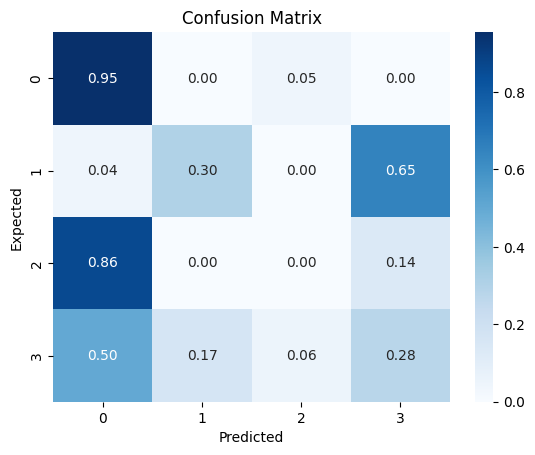

In [24]:
conf_matrix = confusion_matrix(F_test["output"], y_predict_dt)
conf_matrix = conf_matrix.astype(float)
conf_matrix /= conf_matrix.sum(axis=1, keepdims=True)

sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.show()

### Model 2: Random forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

In [26]:
y_predict_rf = rf.predict(X_test)

print(y_predict_rf)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 1 1 1 1 1 1 3 3 3 1 3 3 3 3 3
 3 3 1 3 3 3 3 3 3 2 2 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 1 3 0 0 0 0 3
 3 2 0 3 3 1 1 2 0 0 3]


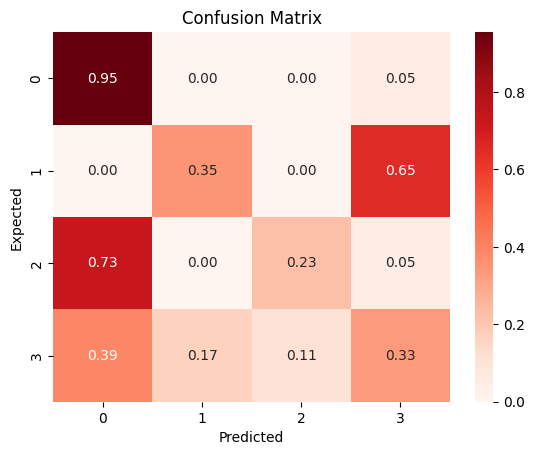

In [27]:
conf_matrix = confusion_matrix(F_test["output"], y_predict_rf)
conf_matrix = conf_matrix.astype(float)
conf_matrix /= conf_matrix.sum(axis=1, keepdims=True)


sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Reds")


plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.show()

In [28]:
print(classification_report(F_test["output"], y_predict_rf))

              precision    recall  f1-score   support

           0       0.48      0.95      0.64        22
           1       0.73      0.35      0.47        23
           2       0.71      0.23      0.34        22
           3       0.26      0.33      0.29        18

    accuracy                           0.47        85
   macro avg       0.54      0.47      0.44        85
weighted avg       0.56      0.47      0.44        85



In [29]:
accuracy = accuracy_score(F_test["output"], y_predict_rf)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 47.06%


### Model 3: Support Vector Machine

In [30]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X, y)

SVC()

In [31]:
y_predict_svm = svm.predict(X_test)

print(y_predict_svm)

[0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 0 0 0 3 3 1 1 1 1 1 3 1 1 1 3 3 3 3 3
 3 3 1 3 3 3 3 3 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 3 3 3 0 2
 1 0 0 3 1 1 1 2 3 1 1]


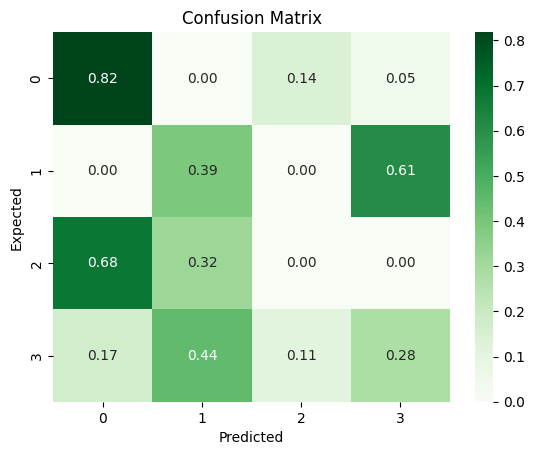

In [32]:
conf_matrix = confusion_matrix(F_test["output"], y_predict_svm)
conf_matrix = conf_matrix.astype(float)
conf_matrix /= conf_matrix.sum(axis=1, keepdims=True)


sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Greens")

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.show()

In [33]:
print(classification_report(F_test["output"], y_predict_svm))

              precision    recall  f1-score   support

           0       0.50      0.82      0.62        22
           1       0.38      0.39      0.38        23
           2       0.00      0.00      0.00        22
           3       0.25      0.28      0.26        18

    accuracy                           0.38        85
   macro avg       0.28      0.37      0.32        85
weighted avg       0.28      0.38      0.32        85



In [34]:
accuracy = accuracy_score(F_test["output"], y_predict_svm)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 37.65%


### Adding variance to the feature set

#### New feature set

In [35]:
window = 150  # samples for every 3 seconds
F = pd.DataFrame()
count = 0

for x in range(0, len(train_df), window):
    # Check that the window has sufficient samples
    if (x + window) < len(train_df):
        count += 1
        d = train_df.loc[x : x + window, :]  # Rows in window range, all columns

        # Calculate features
        feature_values = {
            "sample": x,
            "time": d.iloc[window // 2]["time"],
            "a_mean": d["a"].mean(),
            "a_std": d["a"].std(),
            "variance": d["a"].var(),
            "x_mean": d["x"].mean(),
            "y_mean": d["y"].mean(),
            "z_mean": d["z"].mean(),
            # "x_zero_cross": np.sum(np.diff(np.sign(d["x"])) != 0) / len(d["x"]),
            # "y_zero_cross": np.sum(np.diff(np.sign(d["y"])) != 0) / len(d["y"]),
            # "z_zero_cross": np.sum(np.diff(np.sign(d["z"])) != 0) / len(d["z"]),
            # "skew": d["a"].skew(),
            "output": d.iloc[window // 2]["output"].astype(int),
        }

        F = pd.concat([F, pd.DataFrame(feature_values, index=[0])], ignore_index=True)

        # print("Window: " + str(count))
        # print("Sample x: " + str(x))


# Test set

test_df["a"] = test_df.loc[:, ["x", "y", "z"]].apply(np.linalg.norm, axis=1)

window = 150
count = 0
F_test = pd.DataFrame()

for x in range(0, len(test_df), window):
    # Check that the window has sufficient samples
    if (x + window) < len(test_df):
        count += 1
        d_1 = test_df.loc[x : x + window, :]  # Rows in window range, all columns

        # Calculate features
        test_values = {
            "sample": x,
            "time": d_1.iloc[window // 2]["time"],
            "a_mean": d_1["a"].mean(),
            "a_std": d_1["a"].std(),
            "variance": d_1["a"].var(),
            "x_mean": d_1["x"].mean(),
            "y_mean": d_1["y"].mean(),
            "z_mean": d_1["z"].mean(),
            # "x_zero_cross": np.sum(np.diff(np.sign(d_1["x"])) != 0) / len(d_1["x"]),
            # "y_zero_cross": np.sum(np.diff(np.sign(d_1["y"])) != 0) / len(d_1["y"]),
            # "z_zero_cross": np.sum(np.diff(np.sign(d_1["z"])) != 0) / len(d_1["z"]),
            # "skew": d_1["a"].skew(),
            "output": d_1.iloc[window // 2]["output"].astype(int),
        }

        F_test = pd.concat(
            [F_test, pd.DataFrame(test_values, index=[0])], ignore_index=True
        )

#### Decision tree

In [36]:
X = F.drop(columns=["sample", "time", "output"])
y = F["output"]

dt = tree.DecisionTreeClassifier()
dt.fit(X, y)

X_test = F_test.drop(columns=["sample", "time", "output"])
y_predict_dt = dt.predict(X_test)

print(classification_report(F_test["output"], y_predict_dt))

accuracy = accuracy_score(F_test["output"], y_predict_dt)
print("Accuracy: {:.2f}%".format(accuracy * 100))

              precision    recall  f1-score   support

           0       0.45      1.00      0.62        22
           1       0.78      0.30      0.44        23
           2       0.67      0.09      0.16        22
           3       0.25      0.33      0.29        18

    accuracy                           0.44        85
   macro avg       0.54      0.43      0.38        85
weighted avg       0.55      0.44      0.38        85

Accuracy: 43.53%


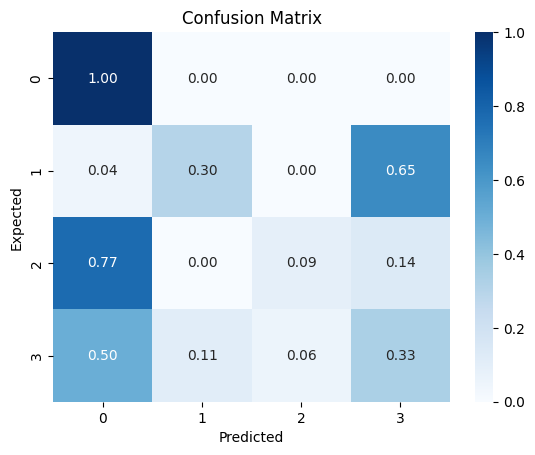

In [37]:
conf_matrix = confusion_matrix(F_test["output"], y_predict_dt)
conf_matrix = conf_matrix.astype(float)
conf_matrix /= conf_matrix.sum(axis=1, keepdims=True)

sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.show()

#### Random forest

In [38]:
X = F.drop(columns=["sample", "time", "output"])
y = F["output"]

rf = RandomForestClassifier()
rf.fit(X, y)

X_test = F_test.drop(columns=["sample", "time", "output"])
y_predict_rf = rf.predict(X_test)

print(classification_report(F_test["output"], y_predict_rf))

accuracy = accuracy_score(F_test["output"], y_predict_rf)
print("Accuracy: {:.2f}%".format(accuracy * 100))

              precision    recall  f1-score   support

           0       0.68      0.95      0.79        22
           1       0.57      0.35      0.43        23
           2       0.88      0.68      0.77        22
           3       0.26      0.33      0.29        18

    accuracy                           0.59        85
   macro avg       0.60      0.58      0.57        85
weighted avg       0.61      0.59      0.58        85

Accuracy: 58.82%


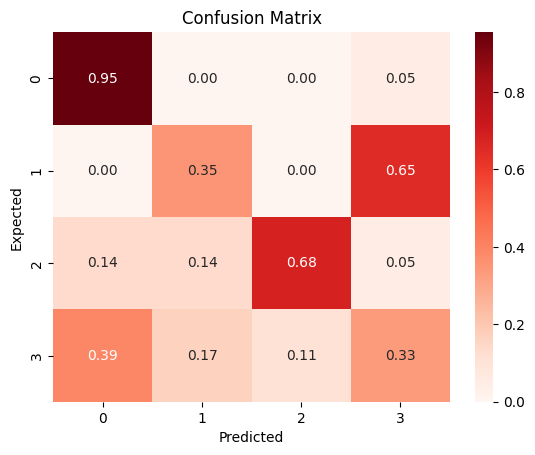

In [39]:
conf_matrix = confusion_matrix(F_test["output"], y_predict_rf)
conf_matrix = conf_matrix.astype(float)
conf_matrix /= conf_matrix.sum(axis=1, keepdims=True)

sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.show()

#### Support Vector Machine

In [40]:
X = F.drop(columns=["sample", "time", "output"])
y = F["output"]

svm = SVC()
svm.fit(X, y)

X_test = F_test.drop(columns=["sample", "time", "output"])
y_predict_svm = svm.predict(X_test)

print(classification_report(F_test["output"], y_predict_svm))

accuracy = accuracy_score(F_test["output"], y_predict_svm)
print("Accuracy: {:.2f}%".format(accuracy * 100))

              precision    recall  f1-score   support

           0       0.56      0.91      0.69        22
           1       0.34      0.43      0.38        23
           2       0.00      0.00      0.00        22
           3       0.24      0.22      0.23        18

    accuracy                           0.40        85
   macro avg       0.28      0.39      0.33        85
weighted avg       0.29      0.40      0.33        85

Accuracy: 40.00%


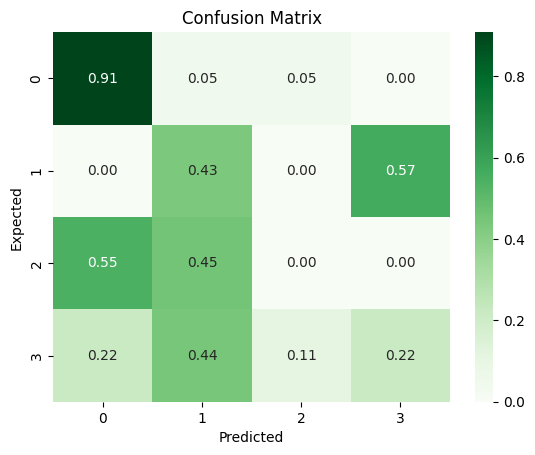

In [41]:
conf_matrix = confusion_matrix(F_test["output"], y_predict_svm)
conf_matrix = conf_matrix.astype(float)
conf_matrix /= conf_matrix.sum(axis=1, keepdims=True)


sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Greens")

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.show()